# Import dataset
Only use this on Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !unrar x "/content/drive/MyDrive/face_detection/pos.rar" "/content/datasets/" 

In [ ]:
# !unrar x "/content/drive/MyDrive/face_detection/neg.rar" "/content/datasets/"

In [ ]:
!cp "/content/drive/MyDrive/face_detection/helper.py" "/content/"

# Import important Library

In [ ]:
import os
from pathlib import Path
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import PReLU
from tensorflow.keras.layers import Flatten

from tensorflow.keras.losses import CategoricalCrossentropy
import helper

from google.colab.patches import cv2_imshow # for image display
import cv2 as cv


# Declare global variables
- Change dataset_path into datasets folder

In [ ]:
CHANNELS = 3
kernel_size = [12, 12]
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
dataset_path = '/datasets/'

# Get data

In [ ]:
# Create path to dataset folder in system
pos_dir = Path(dataset_path + 'pos')
neg_dir = Path(dataset_path + 'neg')
print(pos_dir)
print(neg_dir)

/content/datasets/pos
/content/datasets/neg


In [ ]:
# Get total image in to folder
total_neg_image = len(list(neg_dir.glob('*.jpg')))
total_pos_image = len(list(pos_dir.glob('*.jpg')))

print("Total Positive Image: ", total_pos_image)
print("Total Negative Image: ", total_neg_image)

Total Positive Image:  4777
Total Negative Image:  4901


In [ ]:
# Create dataset using TensorFlow Dataset API
pos_ds = tf.data.Dataset.list_files(str(pos_dir/'*'), shuffle=False)
neg_ds = tf.data.Dataset.list_files(str(neg_dir/'*'), shuffle=False)

# Concatenate two datasets and shuffle
ds = pos_ds.concatenate(neg_ds)
ds = ds.shuffle(total_neg_image + total_pos_image, reshuffle_each_iteration=False)


In [ ]:
# Print out file name in datAset
for f in ds.take(5):
    print(f.numpy())

b'/content/datasets/pos/3458_x1_0.17_y1_0.00_x2_0.83_y2_0.83_.jpg'
b'/content/datasets/neg/303.jpg'
b'/content/datasets/neg/898.jpg'
b'/content/datasets/neg/901.jpg'
b'/content/datasets/pos/3701_x1_0.17_y1_0.00_x2_0.92_y2_0.92_.jpg'


In [ ]:
def get_label(file_path):
    file_split = tf.strings.split(file_path, os.path.sep)
    # 
    if 'pos' == file_split[-2]:
      # Create label
      label = np.array([1, 0], dtype=np.float32).reshape((1, 1, 2))
      # File name example: 3701_x1_0.17_y1_0.00_x2_0.92_y2_0.92_.jpg
      # Split by "_" to extract bounding box
      name_features = tf.strings.split(file_split[-1], '_')
      # Convert to number
      x1 = tf.strings.to_number(name_features[2])
      y1 = tf.strings.to_number(name_features[4])
      x2 = tf.strings.to_number(name_features[6])
      y2 = tf.strings.to_number(name_features[8])
      bbox = [x1, y1, x2, y2]
    else:
      # If file belong to neg -> Set bounding box [0, 0, 0, 0]
      label = np.array([0, 1], dtype=np.float32).reshape((1, 1, 2))
      # Convert to tensorflow Tensor
      bbox = [tf.constant(0, dtype=tf.dtypes.float32) for i in range(4)]
    return tf.convert_to_tensor(label, dtype=tf.float32), tf.reshape(bbox, [1, 1, 4])

In [ ]:
# Print out to test get_label function
for file in ds.take(4):
  print(file.numpy().decode('utf-8'))
  test = get_label(file)
  print('label:', test[0])
  print('bbox:', test[1])
  print('-------------------')

/content/datasets/pos/3458_x1_0.17_y1_0.00_x2_0.83_y2_0.83_.jpg
label: tf.Tensor([[[1. 0.]]], shape=(1, 1, 2), dtype=float32)
bbox: tf.Tensor([[[0.17 0.   0.83 0.83]]], shape=(1, 1, 4), dtype=float32)
-------------------
/content/datasets/neg/303.jpg
label: tf.Tensor([[[0. 1.]]], shape=(1, 1, 2), dtype=float32)
bbox: tf.Tensor([[[0. 0. 0. 0.]]], shape=(1, 1, 4), dtype=float32)
-------------------
/content/datasets/neg/898.jpg
label: tf.Tensor([[[0. 1.]]], shape=(1, 1, 2), dtype=float32)
bbox: tf.Tensor([[[0. 0. 0. 0.]]], shape=(1, 1, 4), dtype=float32)
-------------------
/content/datasets/neg/901.jpg
label: tf.Tensor([[[0. 1.]]], shape=(1, 1, 2), dtype=float32)
bbox: tf.Tensor([[[0. 0. 0. 0.]]], shape=(1, 1, 4), dtype=float32)
-------------------


In [ ]:
def preprocessing(image_path):
    # Get label
    label, bbox = get_label(image_path)
    # Read content from file
    image = tf.io.read_file(image_path)
    # Decode content into jpg image
    image = tf.image.decode_jpeg(image, channels=CHANNELS, dct_method='INTEGER_ACCURATE')
    # Convert to float32 and normalize image
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, {"face_classification": label, "bounding_box_regression": bbox}

In [ ]:
def data_preparation(ds):
  # Cache file and shuffle
  ds = ds.cache().shuffle(len(ds))
  # Load image and get label
  ds = ds.map(preprocessing, num_parallel_calls=AUTOTUNE)
  # Get a batch of images with size = BATCH_SIZE
  ds = ds.batch(BATCH_SIZE)
  # Prepare data in advance
  ds = ds.prefetch(AUTOTUNE)
  return ds

ds = data_preparation(ds)

In [ ]:
# Create model
trainNew = True
if trainNew == True:
  inputs = Input(shape=(12, 12, 3))
  x = Conv2D(10, 3)(inputs)
  x = PReLU()(x)
  x = MaxPooling2D()(x)

  x = Conv2D(16, 3)(x)
  x = PReLU()(x)

  x = Conv2D(32, 3)(x)
  x = PReLU()(x)

  fc_conv = Conv2D(2, 1, padding='same', activation='softmax', name='face_classification')(x)
  bb_reg = Conv2D(4, 1, padding='same', name='bounding_box_regression')(x)
  Pnet = Model(inputs=inputs, outputs=[fc_conv, bb_reg], name='PNet')
elif trainNew == False :
  Pnet = tf.keras.models.load_model("/face_detection/detect_model", compile=False)

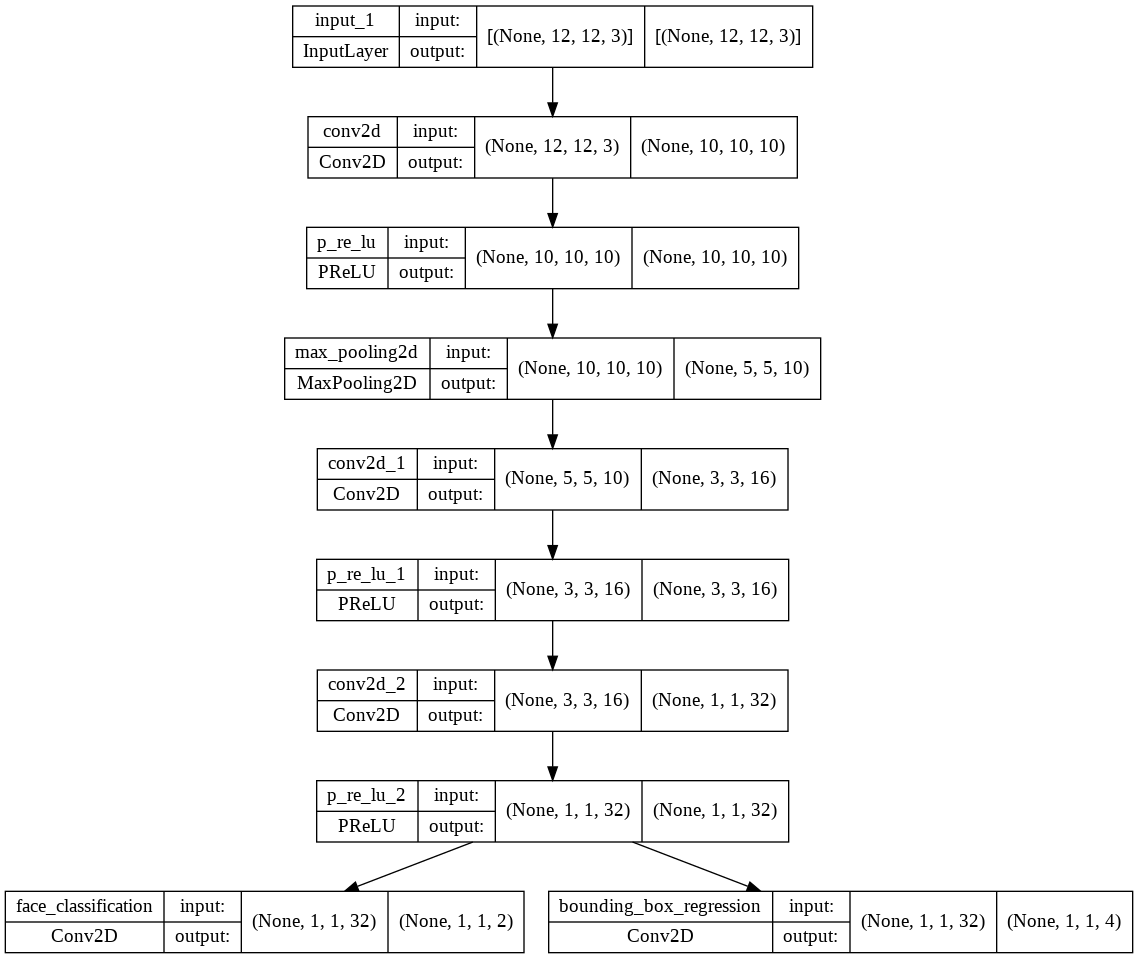

In [ ]:
tf.keras.utils.plot_model(Pnet, 'Pnet.png', show_shapes=True)

In [ ]:
# Custome Euclidean Loss function
class EuclideanLoss(tf.keras.losses.Loss):
  def __init__(self):
    super().__init__()

  def call(self, y_true, y_pred):
    diff = tf.math.square(tf.math.subtract(y_true, y_pred))
    euclidean = tf.math.sqrt(tf.reduce_sum(diff))
    return euclidean


In [ ]:
fc_loss = tf.keras.losses.CategoricalCrossentropy()
box_loss = EuclideanLoss()

fc_metric = tf.keras.metrics.CategoricalCrossentropy()
box_mertic = tf.keras.metrics.MeanSquaredError()

In [ ]:
losses = {
	"face_classification": fc_loss,
	"bounding_box_regression": box_loss
}
metrics = {
	"face_classification": fc_metric,
	"bounding_box_regression": box_mertic
}

In [ ]:
Pnet.compile(
    loss = losses,
    optimizer = 'adam',
    metrics = ['accuracy', fc_metric, box_mertic]
)

In [ ]:
EPOCHS = 150
with tf.device('/device:GPU:0'):
  history = Pnet.fit(
      ds,
      epochs=EPOCHS,
      batch_size=BATCH_SIZE,
      verbose=1,
  )


Epoch 1/150
303/303 [==============================] - 16s 13ms/step - loss: 1.6421 - face_classification_loss: 0.3067 - bounding_box_regression_loss: 1.3353 - face_classification_accuracy: 0.8692 - face_classification_categorical_crossentropy: 0.3067 - face_classification_mean_squared_error: 0.0925 - bounding_box_regression_accuracy: 0.4031 - bounding_box_regression_categorical_crossentropy: 0.8695 - bounding_box_regression_mean_squared_error: 0.0175
Epoch 2/150
303/303 [==============================] - 4s 13ms/step - loss: 0.6460 - face_classification_loss: 0.0295 - bounding_box_regression_loss: 0.6165 - face_classification_accuracy: 0.9955 - face_classification_categorical_crossentropy: 0.0295 - face_classification_mean_squared_error: 0.0045 - bounding_box_regression_accuracy: 0.4361 - bounding_box_regression_categorical_crossentropy: 0.8587 - bounding_box_regression_mean_squared_error: 0.0033
Epoch 3/150
303/303 [==============================] - 4s 13ms/step - loss: 0.4677 - face

In [ ]:
# Save model
Pnet.save("/content/drive/MyDrive/face_detection/detect_model")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/face_detection/detect_model/assets


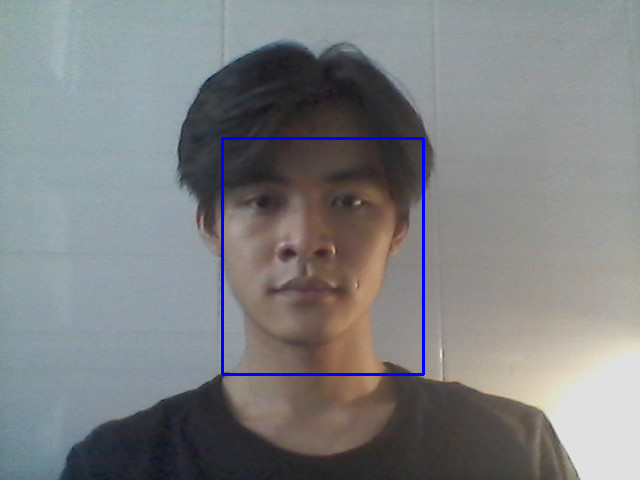

In [ ]:
# Read image
image = cv.imread("/content/WIN_20220525_13_21_22_Pro.jpg")
# opencv turn of BGR format => Convert to RGB and normalize to predict
img_to_detect = cv.cvtColor(image, cv.COLOR_BGR2RGB).astype(np.float32) / 255.0

# Predict bounding box
prediction = helper.pipeline(img_to_detect)[0]
top_left = (int(prediction[0]), int(prediction[1]))
bottom_right = (int(prediction[2]), int(prediction[3]))
# Plot
image = cv.rectangle(image, top_left, bottom_right, (255, 0, 0), thickness=2)
cv2_imshow(image)